# Машинне навчання

## Опис

В цій лабораторній ви будете працювати з набором даних [UCI Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality). Він містить 11 фіч.

## Підготовка

In [2]:
%%capture
%pip install pandas seaborn scikit-learn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Читання даних
В процессі читання даних ми додаємо 12-ту фічу - колір вина.

In [4]:
# Завантажуємо червоне вино
dfr = pd.read_csv("https://gitlab.com/DmyMi/python-training-examples/-/raw/main/04.ml/data/winequality-red.csv", sep=';')
dfr['color'] = 'red'
# Завантажуємо біле вино
dfw = pd.read_csv("https://gitlab.com/DmyMi/python-training-examples/-/raw/main/04.ml/data/winequality-white.csv", sep=';')
dfw['color'] = 'white'
# Об’єднання та перемішування даних
df = pd.concat([dfr, dfw])
df = df.sample(frac=1, random_state=3).reset_index(drop=True)

## Огляд даних

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,5.9,0.180,0.28,1.0,0.037,24.0,88.0,0.99094,3.29,0.55,10.65,7,white
1,10.2,0.670,0.39,1.9,0.054,6.0,17.0,0.99760,3.17,0.47,10.00,5,red
2,8.4,0.715,0.20,2.4,0.076,10.0,38.0,0.99735,3.31,0.64,9.40,5,red
3,6.8,0.370,0.51,11.8,0.044,62.0,163.0,0.99760,3.19,0.44,8.80,5,white
4,8.9,0.750,0.14,2.5,0.086,9.0,30.0,0.99824,3.34,0.64,10.50,5,red


Кількісний розподіл якості вина:

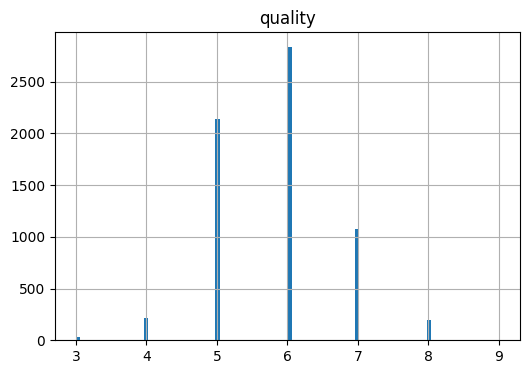

In [7]:
df.hist('quality', bins=100, figsize=(6, 4));

Додамо колонку "клас" для подальшої класифікації:

In [8]:
df['class'] = df.quality.apply(lambda x: "high" if x > 6 else "low")

Візуалізація багатовимірних зв’язків між зразками:

> Примітка: візуалізація може зайняти 1-2 хвилини

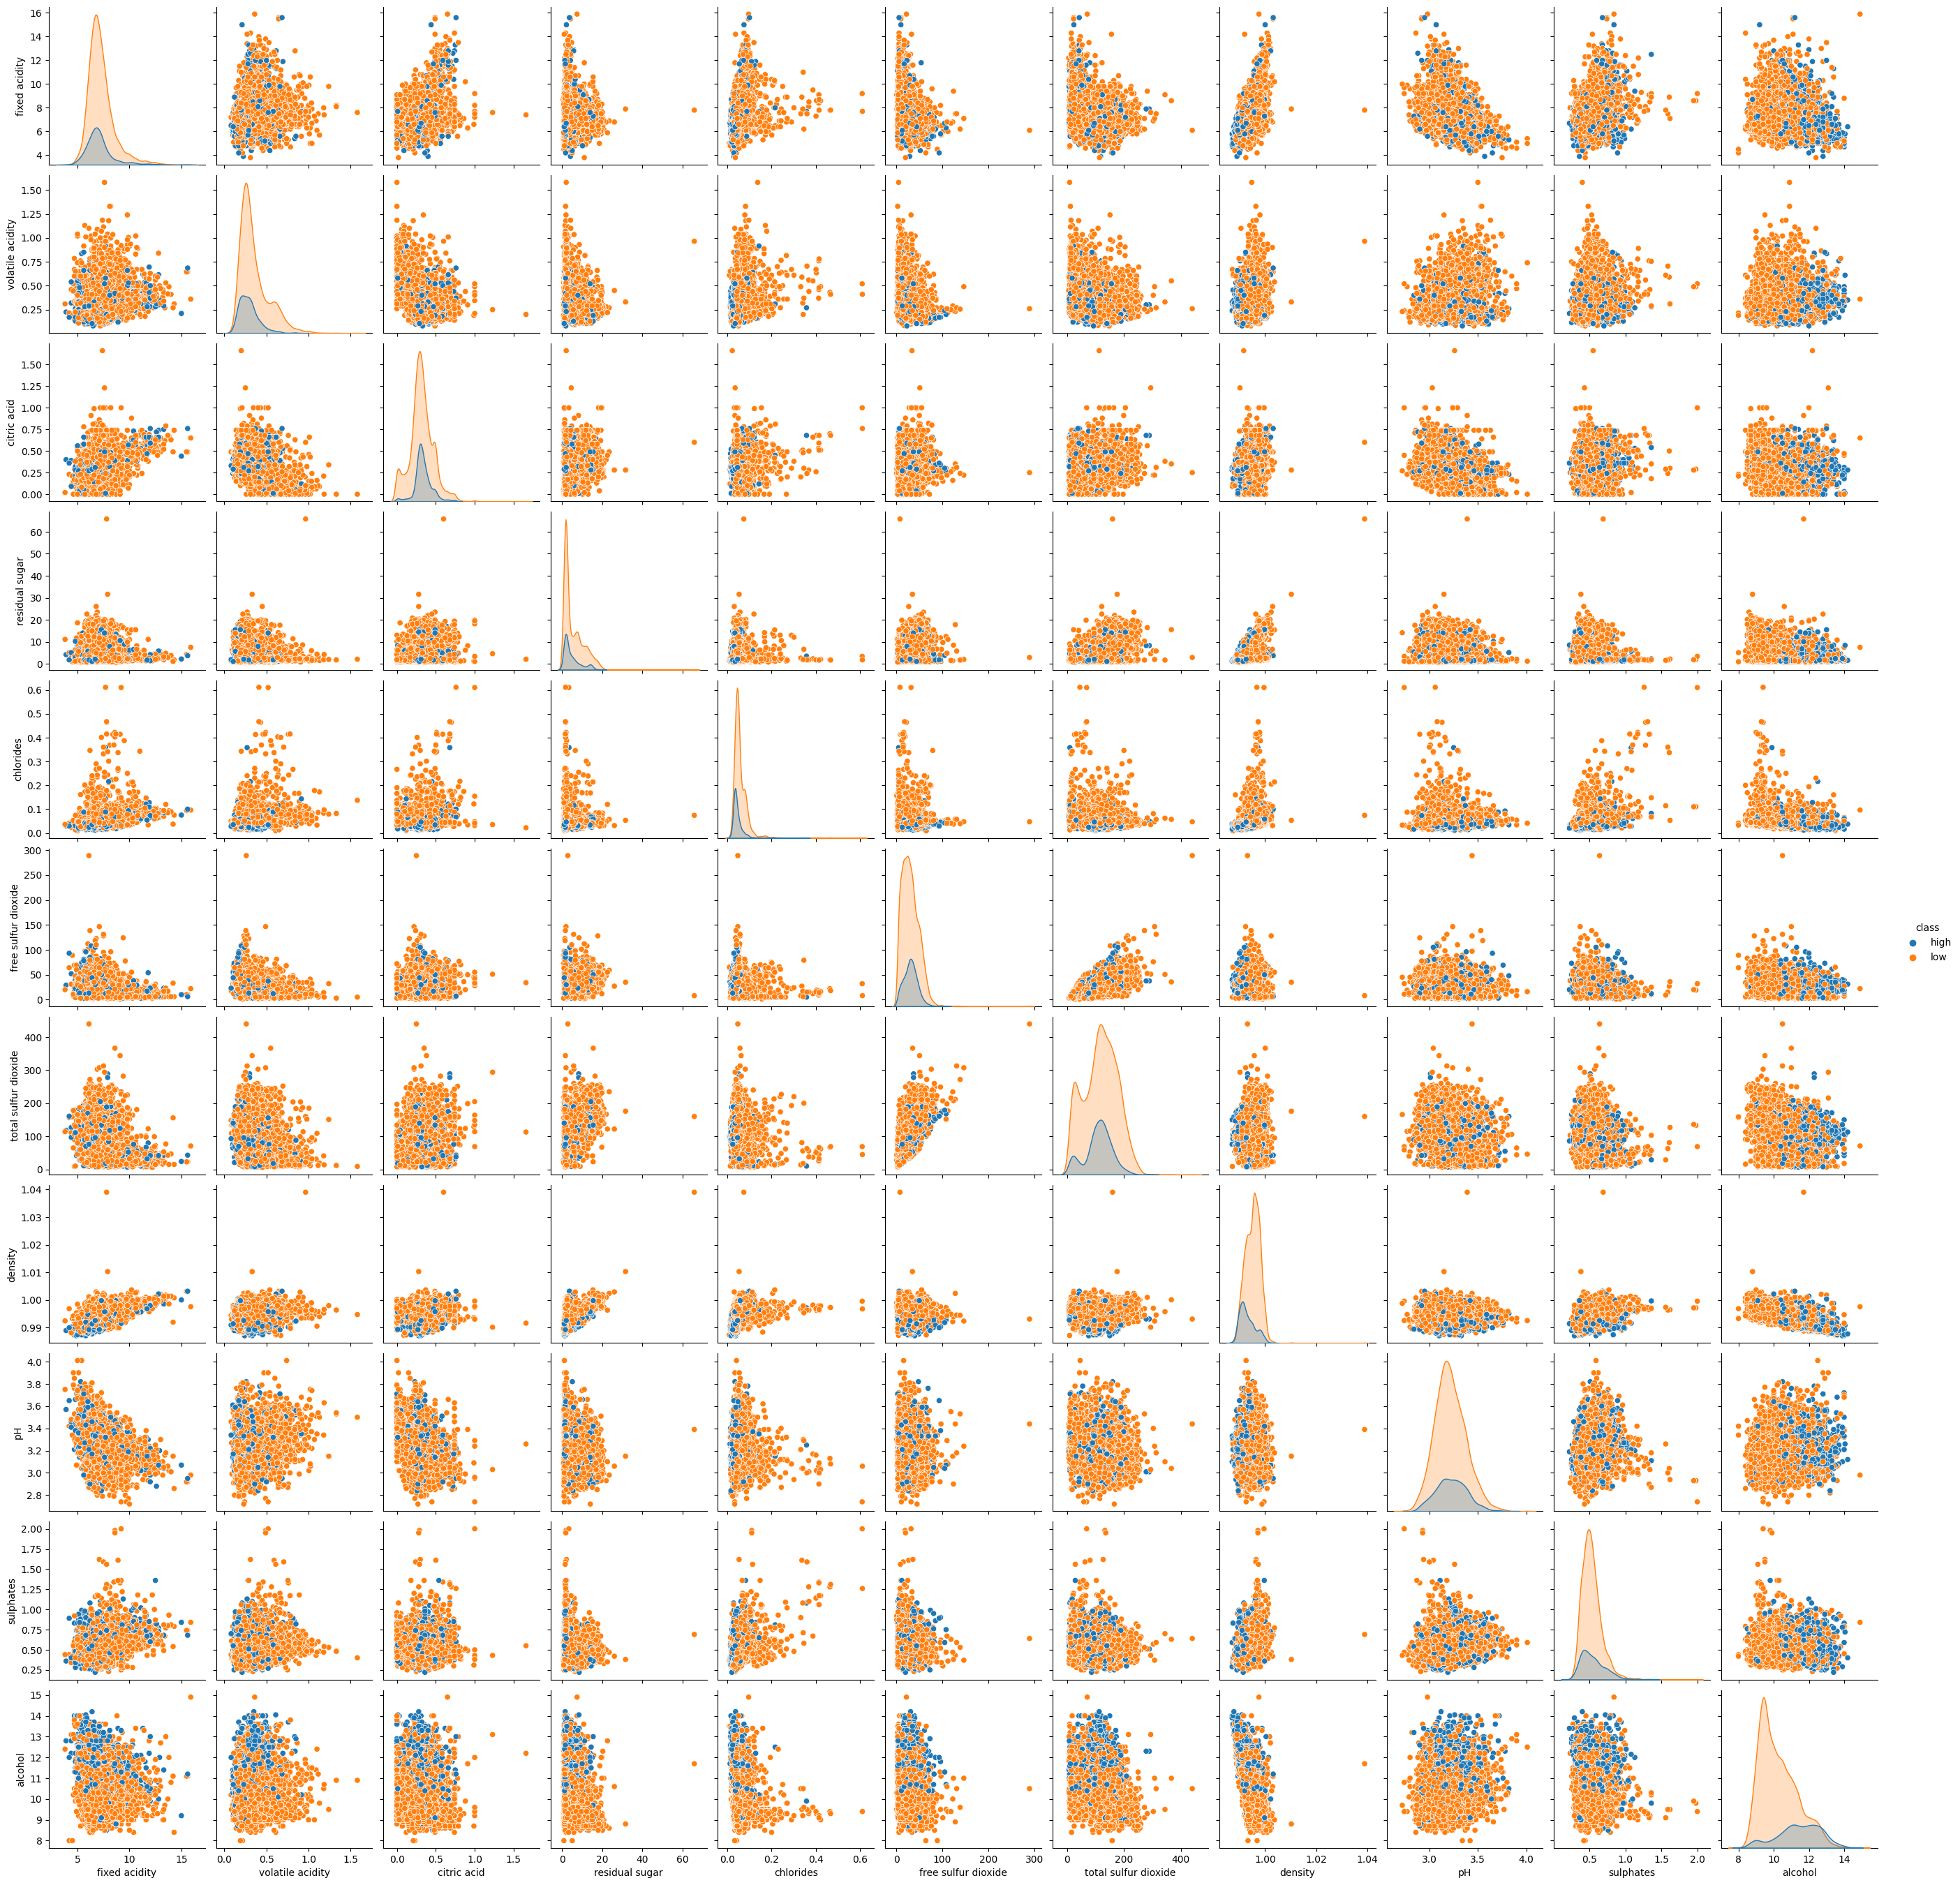

In [9]:
sns.pairplot(df.drop('quality', axis=1), hue='class', height=2.5);

Як видно, багато фіч є корельованими, що також можна побачити за допомогою матриці кореляції:

In [10]:
from matplotlib import colors
import matplotlib.pyplot as plt

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Code by Joe Kington
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def background_gradient(s, cmap='bwr', low=0, high=0):
    """
    Color correlations table according to specified colormap
    """
    rng = s.max() - s.min()
    norm = MidpointNormalize(s.min() - (rng * low), s.max() + (rng * high), 0)
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.colormaps.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df.drop(['color', 'class'], axis=1).corr().style.apply(background_gradient, axis=1).format(precision=2).set_properties(**{'color': 'black'})

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10,-0.08
volatile acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04,-0.27
citric acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.10,-0.33,0.06,-0.01,0.09
residual sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36,-0.04
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26,-0.20
free sulfur dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18,0.06
total sulfur dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.27,-0.04
density,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69,-0.31
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12,0.02
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.26,0.19,1.00,-0.00,0.04


## Лінійна регресія

> Примітка: Залежність якості вина від інших розглянутих фіч є (скоріш за все) нелінійною. Тому точність моделі в цьому завданні буде невеликою.

**Завдання 1**: Відокремте цільове значення `quality`, розділіть дані у співвідношенні 7:3 (30% - набір для тестування, використовуйте `random_state=42`) і попередньо обробіть дані за допомогою `StandardScaler`.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

regression_df = df.drop(['color', 'class'], axis=1)

X = regression_df.drop('quality', axis=1)
y = regression_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Завдання 2**: Навчіть модель LASSO з $\alpha = 0,01$ (слабка регулярізація) і масштабованими даними. Знову встановіть `random_state=42`

In [13]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, random_state=42)

Відсортуйте фічі за їх впливом на цільове значення (якість вина). Майте на увазі, що як великі позитивні, так і великі негативні коефіцієнти означають великий вплив на цільове значення. Тут зручно використовувати `pandas.DataFrame`.

In [15]:
lasso_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
lasso_coefficients = lasso_coefficients.reindex(lasso_coefficients['Coefficient'].abs().sort_values(ascending=False).index)
print(lasso_coefficients)

                 Feature  Coefficient
10               alcohol     0.381063
1       volatile acidity    -0.219966
6   total sulfur dioxide    -0.093599
3         residual sugar     0.084090
9              sulphates     0.078756
5    free sulfur dioxide     0.067353
4              chlorides    -0.031296
8                     pH     0.021105
0          fixed acidity     0.007132
2            citric acid    -0.000000
7                density    -0.000000


**Завдання 3**: Яка фіча є найменш інформативною для прогнозування якості вина, згідно з цією моделлю LASSO?

In [14]:
lasso_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
lasso_coef_sorted = lasso_coef.sort_values(by='Coefficient', key=lambda x: x.abs())
least_informative_feature = lasso_coef_sorted.iloc[0]['Feature']
print(f"Найменш інформативна функція: {least_informative_feature}")

Найменш інформативна функція: citric acid


**Завдання 4**: Навчіть `LassoCV` із `random_state=42`, щоб вибрати найкраще значення $\alpha$ у 5-кратній перехресній перевірці. Скористайтесь масштабованими даними.

In [16]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(alphas=alphas, random_state=42, cv=5)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha = lasso_cv.alpha_
print(f"Найкраще значення alpha: {best_alpha}")

Найкраще значення alpha: 1e-06


**Завдання 5**: Яка фіча є найменш інформативною для прогнозування якості вина, згідно налаштованої моделі LASSO?

In [17]:
lasso_cv_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv.coef_})
lasso_cv_coef_sorted = lasso_cv_coef.sort_values(by='Coefficient', key=lambda x: x.abs())
least_informative_feature_cv = lasso_cv_coef_sorted.iloc[0]['Feature']
print(f"Найменш інформативна функція (після налаштування): {least_informative_feature_cv}")

Найменш інформативна функція (після налаштування): citric acid


**Завдання 6**: Які середнь- квадратичні помилки прогнозування налаштованої моделі LASSO на тренувальному і тестовому наборах даних? Скористайтесь масштабованими даними.

In [20]:
from sklearn.metrics import mean_squared_error

y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Середньо-квадратична помилка (тренувальний набір): {mse_train:.3f}")
print(f"Середньо-квадратична помилка (тестовий набір): {mse_test:.3f}")

Середньо-квадратична помилка (тренувальний набір): 0.532
Середньо-квадратична помилка (тестовий набір): 0.559


## Класифікація

**Завдання 7**: Відокремте цільове значення `class`, розділіть дані у співвідношенні 7:3 (30% - набір для тестування, використовуйте `random_state=42`) і попередньо обробіть дані за допомогою `StandardScaler`.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tree_df = df.drop(['color', 'quality'], axis=1)

X = tree_df.drop('class', axis=1)
y = tree_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Завдання 8**: Навчіть дерево рішень (`random_state=42`). Знайдіть оптимальну максимальну глибину за допомогою 5-кратної перехресної перевірки (`GridSearchCV`). Скористайтесь масштабованими даними.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_params = {"max_depth": range(2, 11)}
tree_classifier = DecisionTreeClassifier(random_state=42)
best_tree = GridSearchCV(tree_classifier, tree_params, cv=5)
best_tree.fit(X_train_scaled, y_train)
print("Best params:", best_tree.best_params_)
print("Best cross validaton score", best_tree.best_score_)

Best params: {'max_depth': 6}
Best cross validaton score 0.8299955270252299


**Завдання 9**: Навчіть дерево рішень із кращою максимальною глибиною `max_depth` яку ви отримаєте у попередньому кроці і обчисліть точність на тестовому набору. Використовуйте параметр `random_state = 42` для відтворюваності. Скористайтесь масштабованими даними.

In [23]:
from sklearn.metrics import accuracy_score

tuned_tree = DecisionTreeClassifier(max_depth=best_tree.best_params_['max_depth'], random_state=42)
tuned_tree.fit(X_train_scaled, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test_scaled)
accuracy = accuracy_score(y_test, tuned_tree_predictions)
print("Точність на тестовому наборі:", accuracy)

Точність на тестовому наборі: 0.8148717948717948


## Зменшення розмірності

Ми знаємо що дані у нас достатньо корельовані, тому ми можемо зменшити кількість фіч при цьому зберігаючи достатню різноманітність даних.

**Завдання 10**: Відокремте цільове значення `class` і попередньо обробіть дані за допомогою `StandardScaler`. Розділяти дані немає необхідності, оскільки ми в подальшому будемо використовувати кластеризацію.

In [24]:
from sklearn.preprocessing import StandardScaler

cluster_df = df.drop(['color', 'quality'], axis=1)

X = cluster_df.drop('class', axis=1)
y = cluster_df['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Завдання 11**: Зменшіть кількість вимірів за допомогою PCA, залишивши стільки компонентів, скільки необхідно для пояснення принаймні 90% дисперсії вихідних (масштабованих) даних. Використовуйте масштабований набір даних і `random_state=42`.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)

**Завдання 12**: Яка мінімальна кількість головних компонентів потрібна для покриття 90% дисперсії вихідних (масштабованих) даних?

In [27]:
min_components = pca.fit(X_scaled).n_components_
print(f"Мінімальна кількість головних компонент для покриття 90% дисперсії: {min_components}")

Мінімальна кількість головних компонент для покриття 90% дисперсії: 7


**Завдання 13**: Який відсоток дисперсії покриває перший головний компонент? Округліть до найближчого відсотка.

In [28]:
pca = PCA(n_components=1, random_state=42)
variance_percentage = pca.fit(X_scaled).explained_variance_ratio_[0] * 100
variance_percentage_rounded = round(variance_percentage)
print(f"Відсоток дисперсії, покритий першим головним компонентом: {variance_percentage_rounded}%")

Відсоток дисперсії, покритий першим головним компонентом: 28%


**Завдання 14**: Візуалізуйте дані в проекції на перші два основні компоненти. Використайте `Seaborn`.

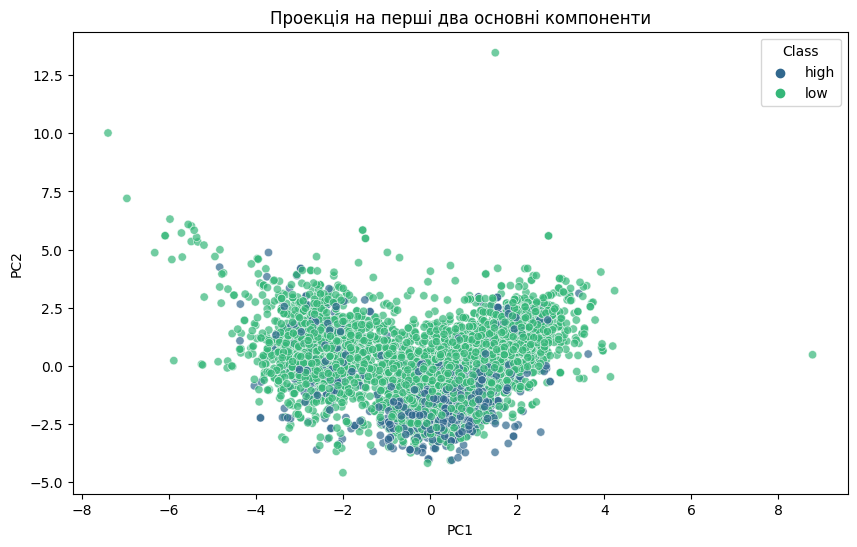

In [29]:
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Проекція на перші два основні компоненти')
plt.show()

Ви побачите якусь кількість кластерів, але можливо побачене вас не втішить :)

## Кластеризація
**Завдання 14**: Виконайте кластеризацію за допомогою методу `KMeans`, навчаючи модель на даних зі зменшеною розмірністю (за допомогою PCA). У цьому випадку ми шукаємо рівно 2 кластери (оскільки ми знаємо що у нас два класи), але в загальному випадку ми не будемо знати, скільки кластерів нам слід шукати.

Опції:
- `n_clusters` = 2 (кількість унікальних міток цільового класу)
- `n_init` = 100
- `random_state` = 42 (для відтворюваності результату)

Інші параметри повинні мати значення за замовчуванням.

In [33]:
from sklearn.cluster import KMeans

# Ваше рішення
kmeans = KMeans(n_clusters=2, n_init=100, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

**Завдання 15**: Візуалізуйте дані в проекції на перші два основні компоненти. Розфарбуйте точки відповідно до отриманих кластерів.

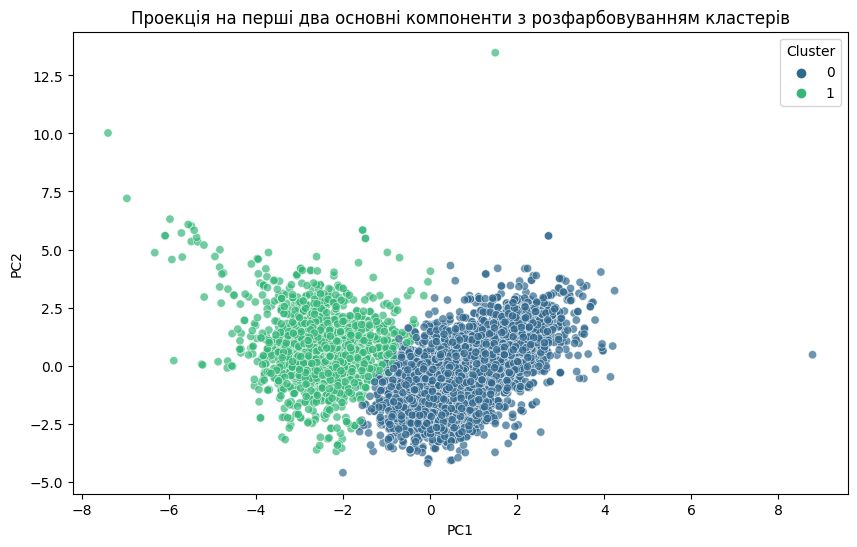

In [34]:
cluster_df_vis = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
cluster_df_vis['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=cluster_df_vis, palette='viridis', alpha=0.7)
plt.title('Проекція на перші два основні компоненти з розфарбовуванням кластерів')
plt.show()

Подивіться на відповідність між позначками кластера та початковими мітками класу, а також на те, як їх плутає `KMeans` :)

In [35]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = [
    "high",
    "low",
    "all",
]
tab.columns = ["cluster" + str(i + 1) for i in range(2)] + ["all"]
tab

,cluster1,cluster2,all
high,1062,215,1277
low,3787,1433,5220
all,4849,1648,6497


Ми бачимо, що для кожного класу є кілька кластерів. Давайте розглянемо максимальний відсоток об’єктів у класі, які віднесли до одного кластеру. Це буде проста метрика, яка характеризує, наскільки легко клас відокремлюється від інших під час кластеризації.

Приклад: якщо для класу «high» (з 1277 екземплярами, що належать до нього), розподіл кластерів є:
  - кластер 1 - 1062
  - кластер 3 - 215

то така частка буде 1062/1277 $ \approx $ 0,83.

**Завдання 16**: Який клас відокремлений краще на основі простого показника, описаного вище?

In [36]:
percentages = tab.iloc[:-1, :-1].div(tab.iloc[:-1, -1], axis=0)
max_percentages = percentages.max(axis=1)
best_separated_class = max_percentages.idxmax()
print("Клас, який відокремлений краще:", best_separated_class)

Клас, який відокремлений краще: high


Можна побачити, що kMeans не дуже добре розрізняє класи. Давайте дізнаємось чи PCA допоможе класифікації (оскільки ми знаємо класи).

**Завдання 17**: Навчіть дерево рішень (`random_state=42`). Знайдіть оптимальну максимальну глибину за допомогою 5-кратної перехресної перевірки (`GridSearchCV`). Скористайтесь даними зі зменшеною розмірністю (за допомогою PCA).

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_params = {"max_depth": range(2, 11)}
tree_classifier_pca = DecisionTreeClassifier(random_state=42)
best_tree_pca = GridSearchCV(tree_classifier_pca, tree_params, cv=5)
best_tree_pca.fit(X_pca, y)
print("Найкращі параметри:", best_tree_pca.best_params_)
print("Найкращий результат крос-валідації:", best_tree_pca.best_score_)

Найкращі параметри: {'max_depth': 10}
Найкращий результат крос-валідації: 0.8239186356368803


Загалом, ситуація не покращилась (або стало гірше). Але (сподіваюсь) стало зрозуміло, що конкретні алгоритми машинного навчання не можна застосувати для рішення всіх задач, і вихідний набір даних впливає їх ефективність.

Тому, дуже часто треба або перебирати різні алгоритми в пошуках того, який краще вирішить задачу або використовувати методи фіча інжинірінгу для допомоги (про що ми поговоримо на наступних лекціях).